# Deconvolution Using In-House V2 Panel

Here we will construct reference matrix to estimate standard cell-type proportions using in-house v2 panel. Our focus is on CRC/AA samples. Thus we will only include broad immune cell-types, abundant non-immune cell-types and colon/small-intestine epithelial cells.

## Initialisation

In [1]:
import os
import numpy as np
import pandas as pd
import random
import glob
import datetime
import itertools
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

### Parameters and File Paths

In [2]:
FILTER_COV = 10
SCORE_VAR = 'frac_alpha_leq_25pct'
#--- Local paths
ROOT_DIR = '/analysis/gh-msun/projects'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG)
DATA_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG) + '/stage'

SAMPLE_PATH = DATA_DIR + '/metadata/samples_wgbs.20230329.tsv'

# Methylation scores for reference WGBS samples.
SCORE_PATH = (
    DATA_DIR + '/ref_methyl_summaries/meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.tsv.gz'
)
# SCORE_PATH = (
#     '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/meth_summaries/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz'
# )

# Region annotation
REGION_PATH = (
    DATA_DIR + '/panel_data/deconvolution_v2.v23_panel_design.tsv.gz'
)
# Where to store deconvolution results
RESULTS_PATH = (
    PROJECT_DIR + '/output/deconv_inhouse_v2'
)

### Sample Metadata

In [3]:
SCORE_PATH

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/stage/ref_methyl_summaries/meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.tsv.gz'

In [4]:
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
ridxs = sample_df['source'].isin(['blueprint_loyfer2022'])
sample_df = sample_df[ridxs].copy()

In [5]:
sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,GSM5652176,Z000000T7,Adipocytes,Adipocytes,53.0,blueprint_loyfer2022,NaN,NaN
1,GSM5652177,Z000000T9,Adipocytes,Adipocytes,35.0,blueprint_loyfer2022,NaN,NaN
2,GSM5652178,Z000000T5,Adipocytes,Adipocytes,37.0,blueprint_loyfer2022,NaN,NaN
3,GSM5652179,Endothelium,Endothelium,Endothelium,33.0,blueprint_loyfer2022,NaN,NaN
4,GSM5652180,Endothelium,Endothelium,Endothelium,62.0,blueprint_loyfer2022,NaN,NaN


In [6]:
summary = sample_df\
    .fillna('none')\
    .groupby(['sample_group'])\
    .size()
summary

sample_group
Adipocytes                3
Bladder-Ep                5
Blood-B                   5
Blood-Granul              3
Blood-Mono+Macro         11
Blood-NK                  3
Blood-T                  22
Blueprint-B              17
Blueprint-CD4            14
Blueprint-CD8            10
Blueprint-Dend            2
Blueprint-Eosi            2
Blueprint-Eryth           2
Blueprint-Macro          18
Blueprint-Mega            2
Blueprint-Mono            8
Blueprint-NK              4
Blueprint-Neutro         21
Bone-Osteob               1
Breast-Basal-Ep           4
Breast-Luminal-Ep         3
Colon-Ep                  8
Colon-Fibro               2
Dermal-Fibro              1
Endothelium              19
Epid-Kerat                1
Eryth-prog                3
Fallopian-Ep              3
Gallbladder               1
Gastric-Ep               11
Head-Neck-Ep             13
Heart-Cardio              6
Heart-Fibro               4
Kidney-Ep                 8
Liver-Hep                 6
Lung-Ep

In [41]:
sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,GSM5652176,Z000000T7,Adipocytes,Adipocytes,53.0,blueprint_loyfer2022,NaN,NaN
1,GSM5652177,Z000000T9,Adipocytes,Adipocytes,35.0,blueprint_loyfer2022,NaN,NaN
2,GSM5652178,Z000000T5,Adipocytes,Adipocytes,37.0,blueprint_loyfer2022,NaN,NaN
3,GSM5652179,Endothelium,Endothelium,Endothelium,33.0,blueprint_loyfer2022,NaN,NaN
4,GSM5652180,Endothelium,Endothelium,Endothelium,62.0,blueprint_loyfer2022,NaN,NaN


In [7]:
# update sample group with cell type for T cell subset
# rest of smaples will be aggregated into Blueprint CD4 or CD8

t_reg_list = ['regulatory T cell']

t_naive_list = ['CD4-positive, alpha-beta T cell',
                'CD8-positive, alpha-beta T cell' ]

t_effector_list = ['effector memory CD8-positive, alpha-beta T cell', 
                 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated',
                 'central memory CD8-positive, alpha-beta T cell']

for index, row in sample_df.iterrows():
    
    if row['cell_type'] in t_reg_list:
        sample_df.at[index, 'sample_group'] = 't_reg'
        
    if row['cell_type'] in t_naive_list:
        sample_df.at[index, 'sample_group'] = 't_naive'
        
    if row['cell_type'] in t_effector_list:
        sample_df.at[index, 'sample_group'] = 't_effector'

In [8]:
summary = sample_df\
    .fillna('none')\
    .groupby(['sample_group'])\
    .size()
summary

sample_group
Adipocytes                3
Bladder-Ep                5
Blood-B                   5
Blood-Granul              3
Blood-Mono+Macro         11
Blood-NK                  3
Blood-T                  22
Blueprint-B              17
Blueprint-CD4             4
Blueprint-Dend            2
Blueprint-Eosi            2
Blueprint-Eryth           2
Blueprint-Macro          18
Blueprint-Mega            2
Blueprint-Mono            8
Blueprint-NK              4
Blueprint-Neutro         21
Bone-Osteob               1
Breast-Basal-Ep           4
Breast-Luminal-Ep         3
Colon-Ep                  8
Colon-Fibro               2
Dermal-Fibro              1
Endothelium              19
Epid-Kerat                1
Eryth-prog                3
Fallopian-Ep              3
Gallbladder               1
Gastric-Ep               11
Head-Neck-Ep             13
Heart-Cardio              6
Heart-Fibro               4
Kidney-Ep                 8
Liver-Hep                 6
Lung-Ep-Alveo             4
Lung-Ep

### Regions

In [9]:
region_df = pd.read_csv(REGION_PATH, sep='\t')
ridxs = (region_df['v23_conv']==1)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1930, 1658)

In [10]:
region_df.head()

,region_chr,region_start,region_end,region_id,target_celltype,subpanel,v23_conv,v23_unconv,region_start_original,region_end_original
0,chr1,1114772,1114971,Immune_Broad_B-chr1:1114772-1114971,Immune_Broad_B,immune_broad,1,1,1114772.0,1114971.0
1,chr1,1157451,1157720,Immune_Broad_NK-chr1:1157451-1157720,Immune_Broad_NK,immune_broad,1,1,1157451.0,1157720.0
2,chr1,1157880,1158277,Immune_Broad_NK-chr1:1157880-1158277,Immune_Broad_NK,immune_broad,1,1,1157880.0,1158277.0
3,chr1,1652589,1652708,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...,external,1,0,1652504.0,1652793.0
4,chr1,1652673,1652792,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...,external,1,1,1652504.0,1652793.0


Duplication is due to the fact that some regions are spread across several MSRE cut-site clusters.

In [11]:
region_df = region_df[['region_id', 'subpanel', 'target_celltype']].drop_duplicates()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [12]:
summary = region_df.groupby(['subpanel', 'target_celltype']).size()
summary

subpanel            target_celltype                                      
external            Literature_Age                                            30
                    Literature_Immune                                         30
                    Loyfer2022_Preprint_Blood-B                               13
                    Loyfer2022_Preprint_Blood-Granul                          13
                    Loyfer2022_Preprint_Blood-Mono+Macro                      15
                    Loyfer2022_Preprint_Blood-NK                              13
                    Loyfer2022_Preprint_Blood-T                               16
                    Loyfer2022_Preprint_Breast-Basal-Ep                       25
                    Loyfer2022_Preprint_Breast-Basal-Ep:Breast-Luminal-Ep     22
                    Loyfer2022_Preprint_Colon-Ep                              13
                    Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-Int-Ep      14
                    Loyfer2022_Prep

### Methylation Scores

In [13]:
score_df = pd.read_csv(SCORE_PATH, sep='\t')
ridxs = score_df['sample_id'].isin(sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(region_df['region_id'])
score_df = score_df[ridxs].copy()
score_df.shape[0], score_df['region_id'].nunique()

(509090, 1648)

In [14]:
score_df = pd.read_csv(SCORE_PATH, sep='\t')
score_df.head()

,sample_id,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
0,GSM5652176,Immune_Broad_Neutro-chr1:9147789-9147871,24,49,39,88,0,3,40,0,1,16,0.125000,0.333333
1,GSM5652177,Immune_Broad_Neutro-chr1:9147789-9147871,22,68,13,81,27,0,37,11,0,15,0.045455,0.727273
2,GSM5652178,Immune_Broad_Neutro-chr1:9147789-9147871,15,43,11,54,12,0,24,3,0,9,0.000000,0.733333
3,GSM5652179,Immune_Broad_Neutro-chr1:9147789-9147871,29,97,12,109,39,0,51,17,0,22,0.034483,0.793103
4,GSM5652180,Immune_Broad_Neutro-chr1:9147789-9147871,17,43,19,62,9,0,28,2,0,11,0.058824,0.529412


In [15]:
ridxs = score_df['sample_id'].isin(sample_df['sample_id'])
ridxs

0          True
1          True
2          True
3          True
4          True
          ...  
632500    False
632501    False
632502    False
632503    False
632504    False
Name: sample_id, Length: 632505, dtype: bool

## Construct Reference Matrix

What samples/regions define reference atlas?

In [33]:
SAMPLE_TO_REF_CELLTYPE_MAP = {   # blue print
    'Blueprint-B': 'immune_b',
    
    't_naive': 'immune_t_naive',
    't_effector' : 'immune_t_effector' , 
    't_reg' : 'immune_treg',
    
    'Blueprint-NK': 'immune_nk',
    'Blueprint-Dend': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Macro': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Mono': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Eosi': 'immune_eosi',
    'Blueprint-Neutro': 'immune_neutro',
    'Blueprint-Eryth': 'immune_eryth',
    'Blueprint-Mega': 'immune_mega',
    'Eryth-prog': 'eryth_prog'
    
}

REGION_TO_REF_CELLTYPE_MAP= {  # hypo panel
    'Immune_Broad_B': 'immune_b',
    
    'Immune_Broad_CD4_plus_CD8': 'immune_t_naive',
    'Immune_Refined_CD4_Reg':'immune_treg',
 #   'Immune_Broad_CD4_plus_CD8': 'immune_treg',
    'Immune_Lymph_CD4_plus_CD8_Activated_wo_CM':'immune_t_effector',
   # 'Immune_Broad_CD4_plus_CD8': 'immune_t_effector',
    
    'Immune_Broad_NK': 'immune_nk',
    'Immune_Broad_Dend_plus_Macro_plus_Mono': 'immune_dend_plus_macro_plus_mono',
    'Immune_Broad_Eosi': 'immune_eosi',
    'Immune_Broad_Neutro': 'immune_neutro',
    'Immune_Refined_Eryth': 'immune_eryth',
    'Immune_Refined_Mega': 'immune_mega',
    'Eryth_prog': 'eryth_prog'

} 

In [34]:
ridxs = (sample_df['source']=='blueprint_loyfer2022')
ridxs &= sample_df['sample_group'].isin(SAMPLE_TO_REF_CELLTYPE_MAP.keys())
ref_sample_df = sample_df[ridxs].copy()
ref_sample_df['ref_celltype'] = ref_sample_df['sample_group'].map(SAMPLE_TO_REF_CELLTYPE_MAP)
ref_sample_df.shape[0], ref_sample_df['sample_id'].nunique(), ref_sample_df['ref_celltype'].nunique()

(99, 99, 11)

In [35]:
ridxs = region_df['target_celltype'].isin(REGION_TO_REF_CELLTYPE_MAP.keys())
ref_region_df = region_df[ridxs][['region_id', 'target_celltype']].drop_duplicates()
ref_region_df['ref_celltype'] = ref_region_df['target_celltype'].map(REGION_TO_REF_CELLTYPE_MAP)
ref_region_df.shape[0], ref_region_df['region_id'].nunique(), ref_region_df['ref_celltype'].nunique()

(349, 349, 11)

In [36]:
# number of regions per cell type
ref_region_df.groupby(['ref_celltype'])['region_id'].nunique()

ref_celltype
eryth_prog                          22
immune_b                            49
immune_dend_plus_macro_plus_mono    13
immune_eosi                         38
immune_eryth                        25
immune_mega                         29
immune_neutro                       29
immune_nk                           53
immune_t_effector                   18
immune_t_naive                      43
immune_treg                         30
Name: region_id, dtype: int64

In [37]:
ridxs = (score_df['number_molecules']>=FILTER_COV)
ridxs &= score_df['sample_id'].isin(ref_sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(ref_region_df['region_id'])
atlas = score_df[ridxs][['sample_id', 'region_id', SCORE_VAR]]\
    .merge(ref_sample_df[['sample_id', 'ref_celltype']])\
    .groupby(['region_id', 'ref_celltype'])\
    [SCORE_VAR].mean()\
    .reset_index()\
    .pivot_table(index='region_id', columns='ref_celltype', values=SCORE_VAR)
atlas.shape

(349, 11)

In [38]:
ridxs = (atlas.isna().sum(axis=1)==0)
atlas = atlas[ridxs].copy()
atlas.shape

(324, 11)

Rearrange columns and rows of atlas matrix to conform to desired order.

In [39]:
ref_region_df = pd.DataFrame({'ref_celltype': list(REGION_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_region_df)
ridxs = ref_region_df['region_id'].isin(atlas.index)
ref_region_df = ref_region_df[ridxs].copy()
ref_sample_df = pd.DataFrame({'ref_celltype': list(SAMPLE_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_sample_df)
atlas = atlas.loc[ref_region_df['region_id'], ref_sample_df['ref_celltype'].unique()]
atlas.shape

(324, 11)

## Reference Matrix Heatmap

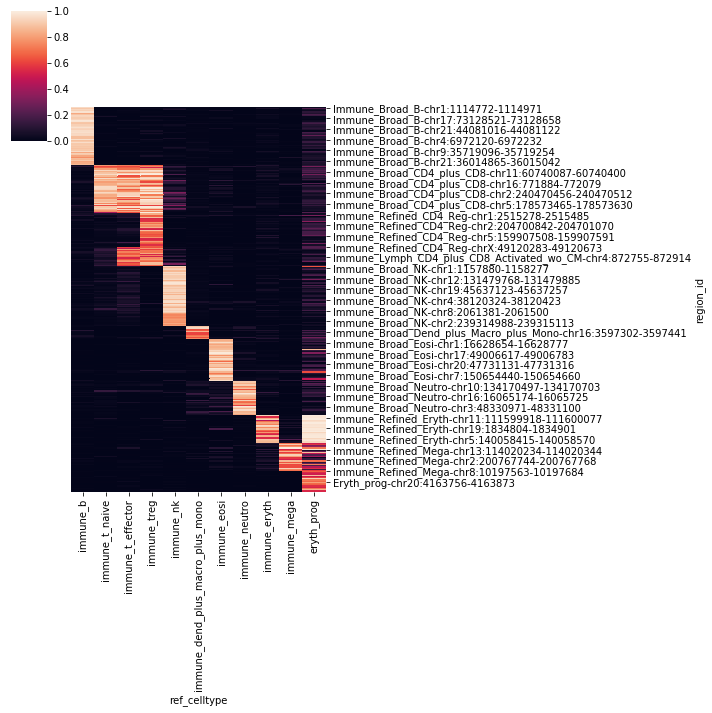

In [40]:
sns.clustermap(atlas, row_cluster=False, col_cluster=False)

## SVD Decomposition of Atlas

In [24]:
u, s, v = np.linalg.svd(atlas, compute_uv=True, full_matrices=False)
s

array([10.41296182,  7.30413219,  6.30453164,  6.27096932,  5.20609951,
        4.5214344 ,  3.48872815,  2.96626373,  2.44193301,  1.92050179,
        1.58999225])

## Write Out

Reference atlas.

In [39]:
ofile = RESULTS_PATH + 't_subset.atlas.tsv.gz'
rv = atlas.reset_index()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Region to reference cell type mapping.

In [40]:
ofile = RESULTS_PATH + '.t_subset.region_to_ref_celltype.tsv.gz'
rv = ref_region_df[['region_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Sample to reference cell type mapping.

In [41]:
ofile = RESULTS_PATH + '.t_subset.sample_to_ref_celltype.tsv.gz'
rv = ref_sample_df[['sample_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)